imports

In [1]:
import tensorflow as tf
#import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np


2024-10-17 15:05:56.491983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Helper and preprocessing functions

In [2]:
def tf_scale_imgs(imgs, scale_factor):
    return imgs * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(imgs.shape)


def tf_scale_labels(labels, scale_factor):
    return labels * scale_factor + 0.5 * (1 - scale_factor) * tf.ones(labels.shape)


def tf_f_inv(x, act_fn):
    """ (activation_size, batch_size) """
    if act_fn == "LINEAR":
        m = x
    elif act_fn == "TANH":
        num = tf.ones_like(x) + x
        div = tf.ones_like(x) - x + 1e-7
        m = 0.5 * tf.math.log(num / div)
    elif act_fn == "LOGSIG":
        div = tf.ones_like(x) - x + 1e-7
        m = tf.math.log((x / div) + 1e-7)
    else:
        raise ValueError(f"{act_fn} not supported")
    return m


def boring_movie(x, y, n_steps=4):
  """Stacks a Tensor to create a 'time series' of repeating images."""
  x = tf.stack([x for _ in range(n_steps)], axis=1)  # make the "boring" movie of subsequently following images
  y = tf.stack([y for _ in range(n_steps)], axis=1)
  return x, y


def random_omissions(x, y, omissions=0.5):
  """Randomly omits a fraction of the images in a batch.""" # why needed? -> not needed here 
  mask = tf.random.uniform(tf.shape(x)[:2], 0, 1)[:, :, None, None, None] > omissions
  x = x * tf.cast(mask, dtype=tf.float32)
  return x, y


def img_preproc(x, y, dtype=tf.float32): # add: tf.image.resize(image, [28,28])
  """Cast input image to a certain tf dtype and normalize them between 0 and 1."""
  x = tf.cast(x, dtype) / 255.
  #x = tf_scale_imgs(x, cf.img_scale)
  #y = tf_scale_labels(y, cf.label_scale)
  #x = tf_f_inv(x, "TANH")
  #y = tf.one_hot(y, depth=10)
  return x, y


def flatten(x, y):
  #flattens a video image series (or batch of images) to (n_batch, n_steps, 1) d.
  shape = tf.shape(x)
  if len(shape) == 5: # hack, determining if it's a video or not
    x = tf.reshape(x, [shape[0], shape[1], -1])
  elif len(shape) == 4:
    x = tf.reshape(x, [shape[0], -1])
  return x, y

resultspath = '/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_{epoch:02d}_{accuracy:.2f}.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= resultspath,  
    monitor='accuracy',         # The metric to monitor for saving (e.g., 'val_loss', 'val_accuracy')
    save_best_only=True,        # Save only the best model 
    save_weights_only=False,    # False = Save the entire model; True = only save weights
    mode='max',                 # Set to 'min' for metrics like loss and 'max' for metrics like accuracy
    save_freq='epoch',          # Frequency of saving, e.g., epoch or batch 
    verbose=1                   # Print when saving a model
)



Load the data

In [3]:
# Create a leading and trailing dataset with tensorflow

img_dir_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Leading/'
img_dir_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Trailing/'
img_dir_test_lead = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Leading/'
img_dir_test_trail = '/Users/denisekittelmann/Documents/Python/BiMoL/data/Test/Test_Trailing/'
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = None # adjust if needed, e.g., 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [ ]:
# Create a leading and trailing dataset with tensorflow

img_dir_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Leading/'
img_dir_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Trailing/' 
img_dir_test_lead = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Leading/' 
img_dir_test_trail = '/scratch/guetlid95/datasets/mcdermott_2024/Stimuli_2/Test/Test_Trailing/' 
class_names_L = ['barn', 'beach', 'cave', 'library', 'restaurant']
class_names_T = ['castle', 'Church', 'conference_room', 'forest'] # changed the order 
batch_size = 32
image_size = (28,28)
validation_split = 0.1
seed = 123

In [4]:
# Create a dict that assigns the correct labels for each leading-trailing img pair

"""
L1 = barn = label 0 
L2 = beach = label 1
L3 = library = label 3
L4 = restaurant = label 4 
L5 = cave = label 2

T6 = Church = label 1   
T7 = conference room = label 2
T8 = castle = label 0   
T9 = forest = label 3

MAPPING:

L1 -> T6 = 0.75 -> (0,1) 
L1 -> T7 = 0.25 -> (0,2)
L1 -> T8 = 0 -> (0,0)
L1 -> T9 = 0 -> (0,3)

L2 -> T6 = 0.75 -> (1,1) 
L2 -> T7 = 0.25 -> (1,2)
L2 -> T8 = 0 -> (1,0)
L2 -> T9 = 0 -> (1,3)

L3 -> T6 = 0 -> (3,1) 
L3 -> T7 = 0 -> (3,2)
L3 -> T8 = 0.5 -> (3,0)
L3 -> T9 = 0.5 -> (3,3)

L4 -> T6 = 0.25 -> (4,1) 
L4 -> T7 = 0.75 -> (4,2)
L4 -> T8 = 0 -> (4,0)
L4 -> T9 = 0 -> (4,3)

L5 -> T6 = 0.25 -> (2,1) 
L5 -> T7 = 0.75 -> (2,2)
L5 -> T8 = 0 -> (2,0)
L5 -> T9 = 0 -> (2,3)

"""

label_dict = {
    (0, 1): 0.0,
    (0, 2): 0.0,
    (0, 0): 0.25,
    (0, 3): 0.75,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 0.25,
    (1, 3): 0.75,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 0.25,
    (3, 3): 0.75,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 0.25,
    (4, 3): 0.75,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 0.5,
    (2, 3): 0.5
}

label_dict = {
    (0, 1): 1.,
    (0, 2): 1.,
    (0, 0): 1.,
    (0, 3): 1.,
    (1, 1): 0.0,
    (1, 2): 0.0,
    (1, 0): 0.,
    (1, 3): 0.,
    (3, 1): 0.0,
    (3, 2): 0.0,
    (3, 0): 0.,
    (3, 3): 0.,
    (4, 1): 0.0,
    (4, 2): 0.0,
    (4, 0): 0.,
    (4, 3): 0.,
    (2, 1): 0.0,
    (2, 2): 0.0,
    (2, 0): 0.,
    (2, 3): 0.
}


def imgsequence(img_t1, img_t2, label_t1, label_t2, label_dict): #data_t1, data_t2, label_dict, batch_size=None
    """This function stacks images and prepares labels accordingly."""
    
    
    img_t1 = tf.cast(img_t1, dtype=tf.float32)
    img_t2 = tf.cast(img_t2, dtype=tf.float32)
    
    # stack imgs from both datatsets into a sequence of 4 img
    x = tf.stack([img_t1, img_t1, img_t2, img_t2], axis = 0)
    #print("Shape of x after stacking:", x.shape)

    
    key_t1 = int(label_t1.numpy())
    key_t2 = int(label_t2.numpy())
   # print("Current label pair:", (key_t1, key_t2))
   
    # Check if the key exists
    if (key_t1, key_t2) in label_dict:
       label_value = label_dict[(key_t1, key_t2)]
        #print(f"Label value found: {label_value}")
    else:
        print(f"Label pair {(key_t1, key_t2)} not found, defaulting to 0")
        label_value = 0  
    
    # Generate the label sequence 
    y_sequence = [[label_value], [label_value], [label_value], [label_value]]
    y = tf.convert_to_tensor(y_sequence, dtype=tf.float32)  # Shape (4, 1)

    #print("Generated labels (y):", y.numpy())
    #print("Shape of y:", y.shape)

    return x, y
 


In [5]:
def generate_dataset(img_dirt1, img_dirt2, class_namest1, class_namest2, label_dict, image_size = None, seed = None):       
    
    tf.random.set_seed(seed)
    
    data_t1 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt1, 
        label_mode = 'int',
        class_names= class_namest1,
        batch_size = None,
        color_mode = 'rgb',
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
        )

    data_t2 = tf.keras.preprocessing.image_dataset_from_directory(
        img_dirt2, 
        label_mode = 'int',
        class_names= class_namest2,
        batch_size = None,
        color_mode = 'rgb', 
        image_size = image_size, 
        #shuffle = True, 
        seed = seed
    )
    
    data_t1.shuffle(99999)
    data_t2.shuffle(99999)
    
    # iterate through shuffled leading and trailing datasets
    leading = iter(data_t1)
    trailing = iter(data_t2) 
              
    while True:
        try:
            # Retrieve single samples
            img_t1, label_t1 = next(leading)
            img_t2, label_t2 = next(trailing)
            #print("test img shapes.", img_t1.shape, img_t2.shape)
            #print("Shape of label_t1:", label_t1.shape)
            #print("Shape of label_t2:", label_t2.shape)

            # Generate x, y pairs for single samples
            x, y = imgsequence(img_t1, img_t2, label_t1, label_t2, label_dict)
            #print("test x:", x.shape)
            #print("test y:", y.shape) 
            yield x, y
            
        except StopIteration:
            # Break the loop if no more samples
            break
        
        
# Create new dataset 
#n_steps = 4
#seed = 123
#batch_size = 32
#dataset = tf.data.Dataset.from_generator(
 #   lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = seed),
  #  output_signature=(
   #     tf.TensorSpec(shape=(n_steps, 28, 28, 3), dtype=tf.float32),  # shape of x 2352; skip batch_size -> dataset.batch()
    #    tf.TensorSpec(shape=(n_steps, 1), dtype=tf.float32)  # shape of y 
    #)
#) 

#print(dataset)

#for x, y in dataset.batch(32).take(1):
#    print("test x:", x.shape)  # Should print (32, 4, 28, 28, 3)
#    print("test y:", y.shape) 
     

In [6]:
# Build val_dataset 
n_steps = 4
seed = 123
#batch_size = 32
val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_dataset(img_dir_test_lead, img_dir_test_trail, class_names_L, class_names_T, label_dict, image_size = (28,28), seed = seed),
    output_signature=(
        tf.TensorSpec(shape=(n_steps, 28, 28, 3), dtype=tf.float32),  # shape of x 2352; skip batch_size -> dataset.batch()
        tf.TensorSpec(shape=(n_steps, 1), dtype=tf.float32)  # shape of y 
    )
) 

print(val_dataset)


<_FlatMapDataset element_spec=(TensorSpec(shape=(4, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1), dtype=tf.float32, name=None))>


In [20]:
class AccuracyPerSequence(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        super(AccuracyPerSequence, self).__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        all_targets = []
        all_predictions = []

        # Iterate over the provided dataset directly
        for batch in self.dataset:
            inputs, targets = batch
            predictions = self.model.predict_on_batch(inputs)

            # Collect predictions and targets for custom accuracy calculations
            all_targets.append(targets)
            all_predictions.append(predictions)
        
        # Perform accuracy calculations here
        print(f"End of epoch {epoch + 1} - Custom Accuracy Calculated per Sequence")


train the network

In [7]:
# define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=32, activation="tanh"), input_shape=(4, 2352)),# First layer + input layer
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=16, activation="tanh")),  # Second layer
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1, activation="sigmoid"))  # Output layer
])

model.build() 
model.compile(optimizer=tf.keras.optimizers.AdamW(),
              metrics=["accuracy"],
              loss="MeanSquaredError",  # "CategoricalCrossentropy" "MeanSquaredError" This is just a sham loss we need so model.evaluate doesn't throw an error. We don't use it.
              )

# evaluate accuracy and train model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten))
print(f"Accuracy before training: {accuracy}")


for epoch in range(1):  
    
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_dataset(img_dir_lead, img_dir_trail, class_names_L, class_names_T, label_dict, image_size=(28, 28), seed=seed),
        output_signature=(
            tf.TensorSpec(shape=(4, 28, 28, 3), dtype=tf.float32),  # shape of x (assuming 4 time steps)
            tf.TensorSpec(shape=(4, 1), dtype=tf.float32)           # shape of y (one label per time step)
        )
    )


    # Train the model for one epoch, but do not reset the model
    history = model.fit(train_dataset.shuffle(99999, reshuffle_each_iteration=True).batch(512).map(img_preproc).map(flatten),
            validation_data=val_dataset.batch(512).map(img_preproc).map(flatten),
            callbacks=[checkpoint_callback], epochs=25)


# Evaluate the model
loss, accuracy = model.evaluate(val_dataset.batch(512).map(img_preproc).map(flatten))
print(f"Accuracy after training: {accuracy}")



/Users/denisekittelmann/miniconda3/envs/BiMo_3.9/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step - accuracy: 0.7750 - loss: 0.1940


2024-10-17 15:06:30.200421: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-17 15:06:30.315131: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/denisekittelmann/miniconda3/envs/BiMo_3.9/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Accuracy before training: 0.7749999761581421
Epoch 1/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
      2/Unknown 4s 305ms/step - accuracy: 0.7925 - loss: 0.1844Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.


2024-10-17 15:06:34.474214: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: accuracy improved from -inf to 0.81869, saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_01_0.82.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.8080 - loss: 0.1721 - val_accuracy: 0.8000 - val_loss: 0.1793
Epoch 2/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
2/4 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step - accuracy: 0.8345 - loss: 0.1497Found 180 files belonging to 5 classes.


2024-10-17 15:06:39.533942: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 180 files belonging to 4 classes.

Epoch 2: accuracy improved from 0.81869 to 0.83663, saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_02_0.84.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 546ms/step - accuracy: 0.8355 - loss: 0.1486 - val_accuracy: 0.8000 - val_loss: 0.1767
Epoch 3/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8379 - loss: 0.1449Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 3: accuracy did not improve from 0.83663
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.8370 - loss: 0.1452 - val_accuracy: 0.8000 - val_loss: 0.1722
Epoch 4/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8286 - loss: 0.1483Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.


2024-10-17 15:06:48.834065: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: accuracy did not improve from 0.83663
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.8347 - loss: 0.1426 - val_accuracy: 0.8000 - val_loss: 0.1668
Epoch 5/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8169 - loss: 0.1535Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 5: accuracy did not improve from 0.83663
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - accuracy: 0.8286 - loss: 0.1442 - val_accuracy: 0.8000 - val_loss: 0.1621
Epoch 6/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8369 - loss: 0.1353Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 6: accuracy did not improve from 0.83663
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.8369 - loss: 0.1352 - val_accuracy: 0.8000 - val_loss: 0.1599
Epoch 7/25
Found 1616

2024-10-17 15:07:07.160070: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 8: accuracy did not improve from 0.83663
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - accuracy: 0.8415 - loss: 0.1272 - val_accuracy: 0.8000 - val_loss: 0.1563
Epoch 9/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8159 - loss: 0.1431Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 9: accuracy did not improve from 0.83663
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 388ms/step - accuracy: 0.8278 - loss: 0.1348 - val_accuracy: 0.8000 - val_loss: 0.1535
Epoch 10/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
2/4 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.8379 - loss: 0.1254Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 10: accuracy did not improve from 0.83663
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step - accuracy: 0.8

2024-10-17 15:07:58.091095: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Found 180 files belonging to 4 classes.

Epoch 16: accuracy improved from 0.83663 to 0.83725, saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_16_0.84.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 539ms/step - accuracy: 0.8349 - loss: 0.0853 - val_accuracy: 0.8250 - val_loss: 0.1284
Epoch 17/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9013 - loss: 0.0704Found 180 files belonging to 5 classes.
Found 180 files belonging to 4 classes.

Epoch 17: accuracy improved from 0.83725 to 0.90006, saving model to /Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/model_checkpoint_17_0.90.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 613ms/step - accuracy: 0.9010 - loss: 0.0707 - val_accuracy: 0.8417 - val_loss: 0.1260
Epoch 18/25
Found 1616 files belonging to 5 classes.
Found 1616 files belonging to 4 classes.
2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9312 - loss

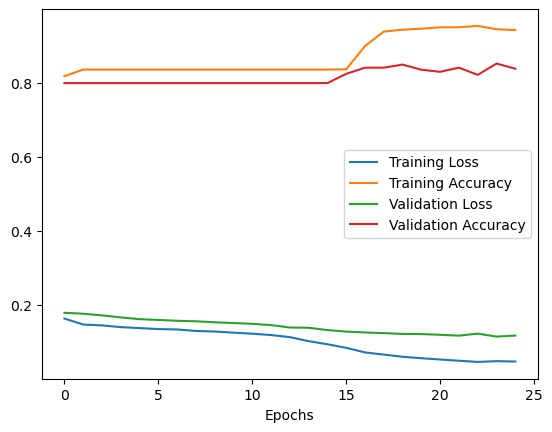

In [8]:

plt.plot(history.history["loss"], label="Training Loss") # val loss 
plt.plot(history.history["accuracy"], label="Training Accuracy")


plt.plot(history.history["val_loss"], label="Validation Loss") # val loss 
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

plt.legend()
plt.xlabel("Epochs")
plt.show()